In [1]:
import pandas as pd 

train = pd.read_csv("/kaggle/input/risk-of-road-accident-dataset/train.csv")
test = pd.read_csv("/kaggle/input/risk-of-road-accident-dataset/test.csv")

print(train.shape, test.shape)
train.head()

(517754, 14) (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

<Axes: >

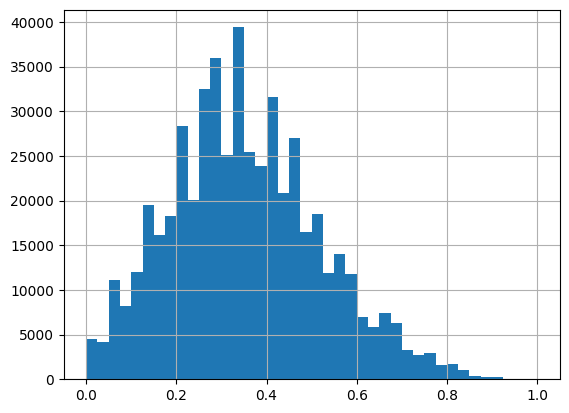

In [2]:
train.info()
train.describe() 
train['accident_risk'].hist(bins=40)  #40 intervals 

In [3]:
# --- XGBOOST 5FOLD CROSS VALIDATION ---
from xgboost import XGBRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

#Seperate target
y = train['accident_risk']

#Add new features - feature engineering 
train['speed_curvature'] = train['speed_limit']*train['curvature']
train['lane_density'] = train['num_reported_accidents']/(train['num_lanes']+1)
train['lighting_weather'] = train['lighting']+'_'+train['weather']

test['speed_curvature'] = test['speed_limit']*test['curvature']
test['lane_density'] = test['num_reported_accidents']/(test['num_lanes']+1)
test['lighting_weather'] = test['lighting']+'_'+test['weather']

train = pd.get_dummies(train, columns=['lighting_weather'])
test = pd.get_dummies(test, columns=['lighting_weather'])
# Combine train + test to ensure consistent dummy columns
all_data = pd.concat([
    train.drop(columns=['id', 'accident_risk']), #risk is extracted to y, no provide to cheat 
    test.drop(columns=['id'])
])
# One-hot encode
all_data = pd.get_dummies(all_data)

# Split back
X = all_data.iloc[:len(train)]
X_test = all_data.iloc[len(train):]

#5 fold cross validation to check model stability 
from sklearn.model_selection import KFold
import numpy as np 

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = [] #create empty list to store RMSE for each fold 

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
#split data manually 
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(
        n_estimators = 400,
        learning_rate = 0.05,
        max_depth = 7,
        subsample = 0.8,
        colsample_bytree = 0.8,
        random_state = 42, 
        n_jobs = -1 #use all Kaggle CPU cores to train faster 
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared = False)
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.5f}")

print("\nXGBOOST Average RMSE across folds:", np.mean(rmse_scores))

Fold 1 RMSE: 0.05624
Fold 2 RMSE: 0.05613
Fold 3 RMSE: 0.05613
Fold 4 RMSE: 0.05598
Fold 5 RMSE: 0.05595

XGBOOST Average RMSE across folds: 0.056086169998196975


In [4]:
import os
os.environ["LIGHTGBM_DEVICE_TYPE"] = "cpu"

In [5]:
# --- LIGHTGBM 5FOLD CROSS VALIDATION ---
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(
        n_estimators=600,     
        learning_rate=0.03,
        max_depth=-1,          # -1 = no explicit limit
        num_leaves=64,         # controls tree complexity
        subsample=0.8,         
        colsample_bytree=0.8, 
        reg_lambda=1.0,        # L2 regularization
        reg_alpha=0.3,         # L1 regularization
        random_state=42
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.5f}")

print("\nLIGHTGBM Average RMSE across folds:", np.mean(rmse_scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 31
[LightGBM] [Info] Start training from score 0.352605
Fold 1 RMSE: 0.05625
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 31
[LightGBM] [Info] Start training from score 0.352104
Fold 2 RMSE: 0.05611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009274 seconds.
You can set `force_row_wise=true` to remov

In [7]:
#--- XGBoost Final Submission ---

#train/validation split from train.csv data
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)

#Train simple model
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=7,
    random_state=42
)
model.fit(X_train, y_train)

# Validate
val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds, squared=False)
print("XGBRegressor Test Validation RMSE:", rmse)

test_preds = model.predict(X_test)
submission = pd.DataFrame({
    "id": test["id"],
    "accident_risk": test_preds 
})

submission.to_csv("XGBOOSTsubmission.csv", index=False)
print("Done")

XGBRegressor Test Validation RMSE: 0.05624770285949325
Done


In [8]:
# --- LightGBM Final Submission ---
from lightgbm import LGBMRegressor 
import pandas as pd

#train/validation split from train.csv data
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)

final_model = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.3,
    random_state=42
)

final_model.fit(X,y)

test_preds = final_model.predict(X_test)

submission = pd.DataFrame({
    'id' : test['id'],
    'accident_risk' : test_preds
})

submission.to_csv('LIGHTGBMsubmission.csv', index=False)
print("Done")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 517754, number of used features: 31
[LightGBM] [Info] Start training from score 0.352377
Done
